In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.spatial.distance import pdist,squareform,euclidean
import pickle
from graphviz import Graph as DOTGraph
import networkx as nx
from collections import Counter

In [ ]:
%%bash
FILE="MetalNet_PDB"
if [ ! -d "$FILE" ]; then 
  mkdir $FILE
fi

In [2]:
cd MetalNet_PDB

/home/cyao/7_PDB_based/MetalNet_PDB


In [3]:
pdb_list = pd.read_csv("list",header=None,sep=" ")
PDB_names = np.array(pdb_list)[:,0]
count = 0

In [ ]:
%%bash
FILE="pdb_data"
if [ ! -d "$FILE" ]; then 
  mkdir $FILE
fi

In [4]:
def get_path(PDB_name,appendix,mode=0,remove_slash=True):
    if mode ==0:
        seq = "data/%s/%s.%s"%(PDB_name[1:3],PDB_name,appendix)
    else:
        seq = "pdb_data/%s/%s.%s"%(PDB_name[1:3],PDB_name,appendix)
    if remove_slash == True:
        seq = seq.replace("\\","")
    return seq

In [5]:
last_count = count
for PDB_name in PDB_names[last_count:]:
    folder_path = get_path(PDB_name,"",1)[0:-1]
    if os.path.exists(folder_path) == False:
        os.makedirs(folder_path)
    pdb_path = get_path(PDB_name,"pdb",1)
    if os.path.exists(pdb_path) == False:
        pdb_path = get_path(PDB_name,"pdb",1,remove_slash=False)   
        os.system("wget -nc -O %s https://files.rcsb.org/download/%s.pdb"%(pdb_path,PDB_name[:-1]))
    count += 1
    if count %100 ==0:
        print(count)
'''
A9/1A92A.pdb
KA/1KAEA.pdb
KD/1KDGA.pdb
KG/1KGSA.pdb
LY/1LY1A.pdb
V4/4V4EA.pdb
V4/4V4EB.pdb
V4/4V4M0.pdb
'''

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800


'\nA9/1A92A.pdb\nKA/1KAEA.pdb\nKD/1KDGA.pdb\nKG/1KGSA.pdb\nLY/1LY1A.pdb\nV4/4V4EA.pdb\nV4/4V4EB.pdb\nV4/4V4M0.pdb\n'

In [6]:
metal_types = ['ZN', 'CA', 'MG', 'CU', 'FE', 'NI', 'MN', 'SF4', 'FES','CO']
hetero_atom = ['O', 'N', 'S'] 
main_chain = ['CA', 'O', 'N', 'C','OXT']

In [7]:
def get_coord(line):
  '''x,y,z'''
  return np.array([line[30:38], line[38:46], line[46:54]],dtype=np.float)

PDB_metal_dict = {}
dist_cutoff = 3 
file_name = "PDB_metal_dict_withaatype.pkl"
redo_flag = False
if os.path.exists(file_name)==False or redo_flag == True:
    for count,PDB_name in enumerate(PDB_names): 
        PDB_chain = PDB_name[-1]
        if count%10==0:
            print(count)
        metal_coord = []
        current_metals = [] 
        HETATMs = os.popen("grep ^HETATM %s "% get_path(PDB_name, 'pdb',1,remove_slash = False)).readlines()
        if len(HETATMs) >0:
            for line in HETATMs:
                if line[20:22].strip()==PDB_chain:
                    metal_type = line[17:20].strip()  
                    if metal_type in metal_types:
                        metal_name = line[22:26].strip()+"_"+metal_type 
                        if metal_name in current_metals:
                            if line[76:78].strip() in ['FE']:
                                metal_coord[-1].append(get_coord(line))
                        else:
                            metal_coord.append([get_coord(line)])
                            current_metals.append(metal_name)
            print(PDB_name,current_metals,metal_coord)        
            assert len(current_metals) == len(metal_coord)
            fake_PDB = open(get_path(PDB_name, 'pdb',0), 'r') 
            handles=fake_PDB.readlines()
            fake_PDB.close()
            
            resi_nums=[]  
            for i in range(len(current_metals)):
                residues = set()
                for j in range(len(metal_coord[i])):
                    print( metal_coord[i][j])
                    for line in handles:
                        if line[:4] == 'ATOM':
                            if line[76:78].strip() in hetero_atom:   
                                if (line[13:16].strip() not in main_chain):  
                                    resi_num = line[17:26].strip()     
                                    atom_coord = np.array(get_coord(line))  
                                    diff = euclidean(atom_coord,metal_coord[i][j])     
                                    if diff < dist_cutoff:
                                        residues.add(resi_num)
                resi_nums.append(residues)
            assert len(resi_nums) == len(current_metals)
            metal = []
            resi = []
            for i in range(len(current_metals)):
                if len(resi_nums[i]) >= 2:
                    metal.append(current_metals[i])
                    resi.append(resi_nums[i])
            if len(metal)>0 :
                PDB_metal_dict[PDB_name] = [metal, resi]    
                print(PDB_name,metal,resi)

    fileObject = open(file_name,'wb') 
    pickle.dump(PDB_metal_dict,fileObject)
    fileObject.close()
else:
    PDB_metal_dict = pickle.load(open(file_name,'rb'))

1768


In [8]:
print(len(PDB_metal_dict.keys()))
statis=[0]*len(metal_types)
m2n = {}
for m,n in zip(metal_types,range(len(metal_types))):
    m2n[m] = n

for PDB_name in list(PDB_metal_dict.keys()):
    idx_ms= PDB_metal_dict[PDB_name][0]
    for idx_m in idx_ms:
        m=idx_m.split('_')[1]
        statis[m2n[m]]+=1
print( list(zip(metal_types,statis) ))

1768
[('ZN', 957), ('CA', 632), ('MG', 403), ('CU', 82), ('FE', 136), ('NI', 92), ('MN', 202), ('SF4', 89), ('FES', 33), ('CO', 40)]


4GGJA [['301_ZN'], [{'CYS A  38', 'HIS A  42', 'CYS A  19', 'CYS A  36'}]]
2PU3A [['300_MG'], [{'ASN A 109', 'GLU A  61'}]]
4LVIA [['201_MN'], [{'HIS A 133', 'GLU A 127', 'HIS A 124', 'HIS A 131'}]]
2ZEXA [['406_CA'], [{'GLU A  13', 'ASP A 139'}]]
3W6WA [['701_CU', '702_CU'], [{'HIS A 106', 'HIS A  70', 'HIS A  97'}, {'HIS A 335', 'HIS A 331', 'HIS A 375'}]]
3KGZA [['1_MN'], [{'HIS A  61', 'GLU A  59', 'HIS A  65', 'HIS A  99'}]]
2NX9A [['601_ZN'], [{'HIS A 208', 'ASP A  16', 'HIS A 206'}]]
3G1PA [['300_ZN', '400_MN', '401_MN'], [{'CYS A  20', 'CYS A  22', 'HIS A 224', 'CYS A  25'}, {'HIS A  77', 'ASP A 163', 'HIS A  75', 'HIS A 142'}, {'HIS A 221', 'ASP A 163', 'HIS A  80'}]]
2FUEA [['500_MG'], [{'ASN A 217', 'ASP A  18'}]]
1IA9A [['2001_ZN'], [{'CYS A 265', 'HIS A 202', 'CYS A 261', 'HIS A 259'}]]
2VPTA [['1235_CA'], [{'ASP A  58', 'ASP A  56', 'ASP A  42'}]]
3NY3A [['1_ZN', '2_ZN', '3_ZN'], [{'CYS A  34', 'CYS A   6', 'CYS A  56', 'CYS A  31'}, {'CYS A  34', 'CYS A  58', 'HIS A  73'

[('ASP', 2310), ('HIS', 2043), ('CYS', 1727), ('GLU', 1257), ('ASN', 319), ('THR', 110), ('SER', 108), ('GLN', 97), ('TYR', 40), ('LYS', 17), ('MET', 13), ('ARG', 5)]


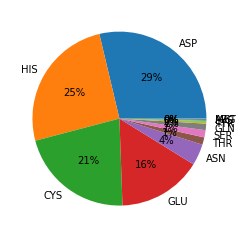

In [9]:
aa=[]
for PDB_name in list(PDB_metal_dict.keys()):
    print(PDB_name,PDB_metal_dict[PDB_name])
    metal_binding=PDB_metal_dict[PDB_name][1]
    for xx in metal_binding:
        for x in xx:
            aa_type=x[:3]
            aa.append(aa_type)
aa=sorted(dict(Counter(aa)).items(),key=lambda x:x[1],reverse=True)
plt.pie([x[1] for x in aa],labels=[x[0] for x in aa],autopct='%1.f%%')
print(aa)

# HHM

In [ ]:
print(len(PDB_metal_dict.keys()))
fileObject = open("metal_list",'w')
fileObject.write("\n".join(list(PDB_metal_dict.keys())))
fileObject.close()

In [ ]:
%%bash
for gene in `cat metal_list`;do
  export folder=`echo $gene|cut -c 2-3`
  export input1="data/$folder/$gene.a3m.gz"
  export output1="pdb_data/$folder/$gene.a3m"
  export output2="pdb_data/$folder/$gene.hhm"
  if [ ! -f $output2 ];then
    gunzip -c $input1 > $output1
    hhsuite-2.0.16-linux-x86_64/bin/hhmake -i $output1 -o $output2
  fi
done

In [ ]:
%%bash
for gene in `cat metal_list`;do
    export folder=`echo $gene|cut -c 2-3`
    export hhmf="pdb_data/$folder/$gene.hhm"
    cat $hhmf >>pdb_data/all.hhm
done

In [ ]:
%%bash
for gene in `cat metal_list`;do
  export folder=`echo $gene|cut -c 2-3`
  export input="pdb_data/$folder/$gene.hhm"
  export output="pdb_data/$folder/$gene.score"
  if [ ! -f $output ];then
    hhsuite-2.0.16-linux-x86_64/bin/hhsearch -cpu 20 -v 0 -alt 1 -i $input -d pdb_data/all.hhm -o /dev/null -scores $output
  fi
done

In [ ]:
!ls pdb_data/??/*.hhm|wc
!ls pdb_data/??/*.score|wc

## cutoff recommendation

    LOG-EVAL< 0 means totally random
    LOG-EVAL > 3 means same fold (Pfam)
    LOG-EVAL > 20 means same function
    LOG-EVAL > 80 means same orthology (two copies in the same species)


In [10]:
uniq_pkl = "uniq.pkl"
uniq_set = set()
redo_flag = False
if os.path.exists(uniq_pkl) == False or redo_flag == True : 
    cluster_dct={}
    count = 0
    for PDB_name in PDB_metal_dict.keys():
        count = count + 1
        cluster_dct.setdefault(PDB_name,[])
        if count %20==0:
            print(count)
        try:
            with open(get_path(PDB_name,"score",1),'r') as f:
                similarity = pd.read_csv(f,header=4,sep=r'\s*',engine='python')
                log_eval = np.array(similarity)[:,-2].astype(np.float) ##LOG-EVAL
                print (PDB_name,log_eval)
                idx = np.where(log_eval> 20)[0]
                if len(idx)>0:    
                    print (idx)
                    idx = idx[0:]
                    gene_list =  np.array(similarity)[:,0][idx]
                    print (gene_list)
                    for gene in gene_list:
                        cluster_dct[PDB_name].append(gene)
        except:
            raise
        sorted_list=tuple(sorted(cluster_dct[PDB_name]))
        uniq_set.add(sorted_list)
    pickle.dump(uniq_set,open(uniq_pkl,'wb'))
else:
    uniq_set = pickle.load(open(uniq_pkl,'rb'))

print( len(uniq_set))   ##1149

1149


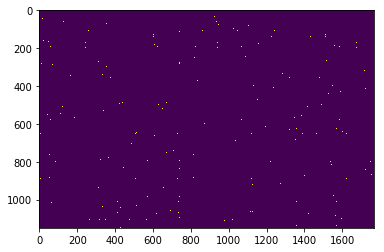

In [11]:
import copy
original=copy.deepcopy(list(uniq_set))
rm_nr_mtx=np.zeros((len(original),len(PDB_metal_dict.keys())),dtype=np.int)
cols_label=tuple(PDB_metal_dict.keys())
for rows_label,x in enumerate(original):
    for i,p in enumerate(cols_label):
        if str(p) in x:
            rm_nr_mtx[rows_label,i]=1

plt.imshow(rm_nr_mtx)

1149


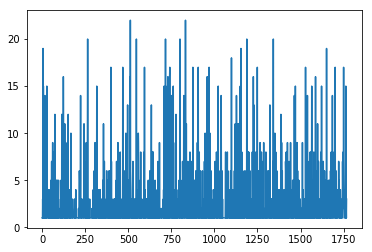

In [12]:
sum_by_r=np.sum(rm_nr_mtx,axis=0)
nr_cluster=np.where(np.sum(rm_nr_mtx,axis=1)>0)[0]
print (len(nr_cluster))
plt.figure()
plt.plot(sum_by_r)
plt.show()

771


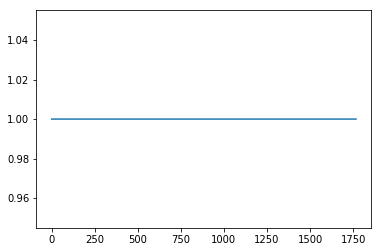

(['2ZGYA'],
 ['4YXPA'],
 ['5DOCA'],
 ['3RZIA'],
 ['4CJ0A', '4ZH5A'],
 ['4TORA'],
 ['4RLEA'],
 ['3PE7A'],
 ['1UI0A'],
 ['3G1PA',
  '3X30A',
  '4XWWA',
  '3M8TA',
  '2R2DA',
  '2E7YA',
  '5ACSA',
  '4OJXA',
  '4XUKA',
  '4ZO2A',
  '3ADRA',
  '4V0HA',
  '3ZWFA',
  '3L6NA',
  '2OHHA',
  '2AZ4A',
  '5EW0A',
  '3BV6A',
  '2P18A',
  '1WRAA',
  '1ZKPA',
  '3DHAA',
  '2P97A',
  '2QEDA',
  '4YSLA',
  '4FGLA',
  '3RPCA',
  '4Z67A',
  '5AXOA',
  '3MD7A',
  '4HL2A'],
 ['2FUEA',
  '2GHTA',
  '3BWVA',
  '1L6RA',
  '2JC9A',
  '3VAYA',
  '2FEAA',
  '4EX6A',
  '2PKEA',
  '3KD3A',
  '4OVYA',
  '3SLRA',
  '2B82A',
  '3QNMA',
  '4FYPA',
  '2WF7A',
  '1Y8AA',
  '2FI1A',
  '2RBKA',
  '3KC2A',
  '3ZVLA',
  '1BIFA',
  '2QLTA',
  '4L57A',
  '1NNLA',
  '4UASA',
  '3ZX4A',
  '2HCFA',
  '3SHQA',
  '1NRWA',
  '1RKQA',
  '3OCUA',
  '2PR7A',
  '2X4DA',
  '4XPZA',
  '1L7MA',
  '1U02A',
  '1ZS9A',
  '1RKUA',
  '3E8MA',
  '4NV0A',
  '4YGSA',
  '1S2OA',
  '4HGNA',
  '2FPRA'],
 ['4HC9A'],
 ['5FGWA'],
 ['3EXMA'],
 ['4K37A'

In [13]:
for c in range(rm_nr_mtx.shape[1]):
    if np.sum(rm_nr_mtx[:,c]) > 1:
        r_pos=np.where(rm_nr_mtx[:,c]==1)
        conc_row=np.sum(rm_nr_mtx[r_pos],axis=0)
        conc_row[np.where(conc_row>1)]=1
        rm_nr_mtx[r_pos[0][0]]=conc_row
        rm_nr_mtx[r_pos[0][1:]]=np.zeros((1,len(PDB_metal_dict.keys())))

nr_cluster=np.where(np.sum(rm_nr_mtx,axis=1)>0)[0]
print (len(nr_cluster))

sum_by_r=np.sum(rm_nr_mtx,axis=0)
plt.figure()
plt.plot(sum_by_r)
plt.show()

uniq_subs=[]
uniq_mtx=rm_nr_mtx[np.where(np.sum(rm_nr_mtx,axis=1)>0)]
for i_subs in range(uniq_mtx.shape[0]):
    cs=np.where(uniq_mtx[i_subs,:]==1)[0]
    subs=list()
    for c in cs:
        subs.append(cols_label[c])
    uniq_subs.append(subs)
uniq_subs=tuple(uniq_subs)
uniq_subs #771

In [ ]:
tmp=open("uniq_subs.pkl",'wb')
pickle.dump(uniq_subs,tmp)
tmp.close()

In [15]:
def get_represent(sub):
    sub_neff=[]
    for PDB_name in sub:
        line=os.popen('grep %s ./list'%(PDB_name),'r').readline()
        seq80=float(line.split()[1])
        with open(get_path(PDB_name,"mtx_ref"),'r') as f:
            pdb_seq=f.readline().strip()
        seq_len = len(pdb_seq)
        neff=seq80/np.sqrt(seq_len)
        sub_neff.append((PDB_name,neff,seq80))
    sub_neff.sort(key=lambda x:x[1],reverse=True)
    return(sub_neff[0][0])
get_represent(uniq_subs[1])

'4YXPA'

# GREMLIN DICT

In [17]:
class PROTEIN:
    def __init__(self):
        self.sequence = str()
        self.gene_name = str()
        self.gap_dict = {}
        self.CHED_seq = str()
        self.CHED_dict = {}
        self.GREMLIN_CM = []

In [18]:
Tome_pkl = "Tome.pkl"
redo_flag = False
if os.path.exists(Tome_pkl) == False or redo_flag == True: 
    CHED_list = ["C","H","E","D"]
    metal_sum = 0
    Tome_dict = {}
    for pdb_count,subs in enumerate(uniq_subs):
        PDB_ID=get_represent(subs) 
        if pdb_count%10==0:
            print(pdb_count)
        Tome_dict.setdefault(PDB_ID,PROTEIN())
        Protein = Tome_dict[PDB_ID]
        Protein.gene_name = PDB_ID
        ref_contents = open(get_path(PDB_ID,"mtx_ref",0),'r').readlines()
        pdb_seq = ref_contents[0].strip()
        GREMLIN_seq = ref_contents[1].strip()
        Protein.sequence = pdb_seq 
        
        GM_AA_count = 0
        gap_dict=dict()
        for i,AA in enumerate(GREMLIN_seq):
            if AA!="-":
                gap_dict[GM_AA_count] = i
                GM_AA_count+=1
        Protein.gap_dict = gap_dict                    

        ncol = len(pdb_seq)
        CHED_mask = np.zeros(ncol)
        for i,AA in enumerate(pdb_seq):
            if AA in CHED_list:
                CHED_mask[i]=1
        CHED_idx = np.where(CHED_mask==1)[0]
        Protein.CHED_seq = "".join(([pdb_seq[AA] for AA in CHED_idx]))      
        CHED_dict = {key:i for (i,key) in enumerate(CHED_idx)}
        Protein.CHED_dict=CHED_dict
        
        CHED_ncol = len(CHED_idx)
        GREMLIN_CM = np.zeros((CHED_ncol,CHED_ncol))
        mtx_file = get_path(PDB_ID,"mtx",0)       
        GREMLIN_result = np.array(pd.read_csv(mtx_file,sep='\t',header=None))
        GREMLIN_result= GREMLIN_result[:,0:-1]
        temp = GREMLIN_result.flatten()
        cutoff = sorted(temp,reverse=True)[4*ncol]  #top 2L 
        GREMLIN_result = GREMLIN_result > cutoff
        for i in range(GREMLIN_result.shape[0]):
            ori_i = gap_dict[i]
            if ori_i in CHED_idx:
                for j in range(GREMLIN_result.shape[0]):
                    ori_j = gap_dict[j]
                    if ori_j in CHED_idx:
                        GREMLIN_CM[CHED_dict[ori_i],CHED_dict[ori_j]] =  GREMLIN_result[i,j]            
        np.fill_diagonal(GREMLIN_CM,0)
        Protein.GREMLIN_CM = GREMLIN_CM  
        
    pickle.dump(Tome_dict,open(Tome_pkl,'wb'))
else:
    Tome_dict = pickle.load(open(Tome_pkl,'rb'))

# graph

In [19]:
def find_ring(subG):
    g=nx.Graph(subG)
    while ([d<2 for (n,d) in list(g.degree())].count(True)>0):
        for (n,d) in list(g.degree()):
            if d<2:
                g.remove_node(n)
    return g

In [20]:
def color_def(elem):
    if elem=="C":
        color="#FFED97"
    elif elem=="H":
        color="#66B3FF"
    elif elem=="E":
        color="#FFA6FF"
    elif elem =="D":
        color="#D3A4FF"
    return color

# load data

In [22]:
ML_data=[]
for gene in list(Tome_dict.keys()):
    Protein=Tome_dict[gene]
    metal_nms=[]
    metal_nms_label=[]
    metals,metal_binding=PDB_metal_dict[gene] 
    print(gene,PDB_metal_dict[gene])
    for idx,xx in enumerate(metal_binding):
        for x in xx:
            metal_nms.append(str(x[5:].strip()))
            metal_nms_label.append(metals[idx])    
            
    reverse_CHED_dict={int(Protein.CHED_dict[k]):str(k) for k in list(Protein.CHED_dict.keys())}
    for i,j in list(zip(list(np.where(Protein.GREMLIN_CM > 0)[0]),list(np.where(Protein.GREMLIN_CM > 0)[1]))):
        if i<j:
            ori_i=reverse_CHED_dict[i]
            ori_j=reverse_CHED_dict[j]
            if (ori_i in metal_nms) and (ori_j in metal_nms):
                print(ori_i,ori_j)
                if metal_nms_label[metal_nms.index(ori_i)] == metal_nms_label[metal_nms.index(ori_j)]:
                    metal_label=metal_nms_label[metal_nms.index(ori_j)].split('_')[1]
                else:
                    i_label=metal_nms_label[metal_nms.index(ori_i)].split('_')
                    j_label=metal_nms_label[metal_nms.index(ori_j)].split('_')
                    gap=abs(int(j_label[0])-int(i_label[0]))
                    metal_label=(''.join((i_label[1],str(gap),j_label[1])))
                ML_data.append((gene,metal_label,(i,j),'positive'))
            elif (ori_i not in metal_nms) and (ori_j not in metal_nms):
                ML_data.append((gene,'',(i,j),'negative'))
    
ML_data=np.array(ML_data)
print(np.where(ML_data[:,-1]=='positive')[0].shape)
print(np.where(ML_data[:,-1]=='negative')[0].shape)

4GGJA [['301_ZN'], [{'CYS A  38', 'HIS A  42', 'CYS A  19', 'CYS A  36'}]]
38 42
2PU3A [['300_MG'], [{'ASN A 109', 'GLU A  61'}]]
4LVIA [['201_MN'], [{'HIS A 133', 'GLU A 127', 'HIS A 124', 'HIS A 131'}]]
124 127
124 131
124 133
127 131
127 133
131 133
4YZ0A [['201_CA', '202_CA', '203_CA'], [{'GLN A  47', 'GLU A  94', 'ASP A 117'}, {'GLN A  49', 'GLU A  94'}, {'ASP A  95', 'GLU A  94', 'ASP A  74'}]]
94 95
95 117
3AG3F [['99_ZN'], [{'CYS F  61', 'CYS F  59', 'CYS F  84', 'CYS F  81'}]]
59 61
59 81
59 84
61 81
61 84
81 84
4DJAA [['603_SF4'], [{'CYS A 453', 'CYS A 440', 'CYS A 437', 'CYS A 349'}]]
349 437
349 440
349 453
437 440
437 453
440 453
4CVBA [['1607_CA', '1610_ZN', '1612_ZN'], [{'GLN A 183', 'GLU A 298'}, {'ASP A 313', 'GLU A 466'}, {'SER A 511', 'GLU A 508'}]]
3EN8A [['128_CA'], [{'ASP A  31', 'ASP A  32'}]]
31 32
1IA9A [['2001_ZN'], [{'CYS A 265', 'HIS A 202', 'CYS A 261', 'HIS A 259'}]]
202 259
202 261
202 265
259 261
259 265
261 265
2VPTA [['1235_CA'], [{'ASP A  58', 'ASP A 

34 36
34 372
36 146
4XB6D [['302_ZN'], [{'CYS D 265', 'CYS D 243', 'CYS D 271', 'CYS D 240'}]]
243 265
243 271
265 271
3ZJAA [['999_CU'], [{'MET A  90', 'MET A  66', 'HIS A  88', 'HIS A  59'}]]
2X3JA [['1590_MG'], [{'ASN A 446', 'GLN A 445', 'ASP A 463'}]]
1K77A [['300_MG'], [{'ASP A 177', 'GLN A 203', 'GLU A 142', 'GLU A 239'}]]
142 239
177 239
4LIMA [['401_ZN'], [{'CYS A 117', 'CYS A 124', 'CYS A 127', 'CYS A 118'}]]
117 118
117 124
117 127
118 124
118 127
124 127
4KJMA [['206_ZN'], [{'HIS A 120', 'GLU A 124'}]]
3IRBA [['201_ZN'], [{'CYS A  66', 'CYS A  63', 'CYS A  49', 'CYS A  52'}]]
49 52
49 63
49 66
52 63
52 66
63 66
3MHSC [['100_ZN'], [{'CYS C  91', 'CYS C  75', 'CYS C  72', 'HIS C  87'}]]
4YH8A [['301_ZN', '302_ZN'], [{'CYS A  32', 'CYS A  17', 'CYS A  26', 'HIS A  36'}, {'CYS A 156', 'HIS A 166', 'CYS A 162', 'CYS A 148'}]]
17 26
17 32
17 36
26 36
26 148
32 36
148 156
156 162
156 166
162 166
3P3CA [['401_ZN'], [{'HIS A  72', 'ASP A 228', 'HIS A 224'}]]
2UURA [['601_ZN'], [{'AS

(2003,)
(10747,)


In [25]:
protein_list = set(list(ML_data[:,0]))
total_samples = len(set(list(ML_data[:,0])))

print(len(protein_list)) #745

745


# nf filter

In [27]:
def get_neff(PDB_name):
    line=os.popen('grep %s ./list'%(PDB_name),'r').readline()
    seq80=float(line.split()[1])
    ref_contents = open(get_path(PDB_name,"mtx_ref"),'r').readlines()
    pdb_seq = ref_contents[0].strip()
    seq_len = len(pdb_seq)
    neff=seq80/np.sqrt(seq_len)
    return(float(neff))
nf_dict={}
for PDB_name in protein_list:
    nf=get_neff(PDB_name)
    nf_dict[PDB_name]=nf
len(nf_dict)

745

In [28]:
nf_filter_protein_list=[]
for PDB_name in nf_dict.keys():
    if nf_dict[PDB_name] > 10:
        nf_filter_protein_list.append(PDB_name)
print(len(nf_filter_protein_list))

499


In [29]:
for gene in nf_filter_protein_list:
    print(ML_data[np.where(ML_data[:,0]==gene)])

[['4LVIA' '' (0, 15) 'negative']
 ['4LVIA' '' (1, 7) 'negative']
 ['4LVIA' '' (10, 11) 'negative']
 ['4LVIA' '' (12, 13) 'negative']
 ['4LVIA' '' (12, 30) 'negative']
 ['4LVIA' '' (16, 19) 'negative']
 ['4LVIA' '' (19, 21) 'negative']
 ['4LVIA' '' (19, 33) 'negative']
 ['4LVIA' '' (20, 21) 'negative']
 ['4LVIA' '' (23, 32) 'negative']
 ['4LVIA' '' (23, 37) 'negative']
 ['4LVIA' 'MN' (25, 27) 'positive']
 ['4LVIA' 'MN' (25, 28) 'positive']
 ['4LVIA' 'MN' (25, 29) 'positive']
 ['4LVIA' 'MN' (27, 28) 'positive']
 ['4LVIA' 'MN' (27, 29) 'positive']
 ['4LVIA' 'MN' (28, 29) 'positive']
 ['4LVIA' '' (31, 33) 'negative']
 ['4LVIA' '' (34, 36) 'negative']]
[['4I4TA' '' (0, 1) 'negative']
 ['4I4TA' '' (0, 2) 'negative']
 ['4I4TA' '' (0, 7) 'negative']
 ['4I4TA' '' (1, 2) 'negative']
 ['4I4TA' '' (1, 3) 'negative']
 ['4I4TA' '' (1, 80) 'negative']
 ['4I4TA' '' (3, 7) 'negative']
 ['4I4TA' '' (4, 5) 'negative']
 ['4I4TA' '' (4, 6) 'negative']
 ['4I4TA' '' (4, 7) 'negative']
 ['4I4TA' '' (4, 41) 'n

In [ ]:
file=open("nf_filter_protein_list",'w')
file.write('\n'.join(nf_filter_protein_list))
file.write('\n')
file.close()

## 2d motif bank

In [32]:
motif_bank={}
for gene in nf_filter_protein_list:
    
    logical_positive=np.logical_and(ML_data[:,-1]=='positive',ML_data[:,0]==gene)
    per_gene_data=ML_data[np.where(logical_positive)]
    pos_CHED_list=list(per_gene_data[:,2])
    print(per_gene_data)
    G=nx.from_edgelist(pos_CHED_list)
    
    Protein = Tome_dict[gene]
    reverse_CHED_dict={int(Protein.CHED_dict[k]):str(k) for k in Protein.CHED_dict.keys()}
    for c in nx.connected_components(G):
        nodeset=G.subgraph(c).nodes()
        if len(nodeset)<3:          
            continue
        subG=nx.Graph(G.subgraph(c))
        subG=find_ring(subG)
        pair_list = nx.to_edgelist(subG) 
        print(gene,pair_list)
        if len(pair_list) >=2:      
            for pair in pair_list:        
                i_tag=pair[0]
                j_tag=pair[1]
                ori_i=reverse_CHED_dict[i_tag]
                ori_j=reverse_CHED_dict[j_tag]
                iAA=Protein.sequence[int(ori_i)]
                jAA=Protein.sequence[int(ori_j)]
                i_id=str(ori_i)+iAA                
                j_id=str(ori_j)+jAA  
                attrs={i_tag:{'residue':iAA,'id':i_id},j_tag:{'residue':jAA,'id':j_id}}
                nx.set_node_attributes(subG,attrs)
                
                if int(i_tag) < int(j_tag):
                    metal_label= per_gene_data[pos_CHED_list.index((i_tag,j_tag)),1]
                else:
                    metal_label= per_gene_data[pos_CHED_list.index((j_tag,i_tag)),1]
                attrs={(i_tag,j_tag):{'metal':metal_label,'gap':abs(int(ori_i)-int(ori_j)),'gap_label':(abs(int(ori_i)-int(ori_j))<3)}}
                nx.set_edge_attributes(subG,attrs)   
            subG_metal=set(nx.get_edge_attributes(subG,'metal').values())
            print(nx.get_node_attributes(subG,'id'))
            if len(subG_metal) ==1:
                subG_metal=tuple(subG_metal)[0]
                motif_bank.setdefault(str(subG_metal),[])
                motif_bank[str(subG_metal)].append((gene,subG))
                print(gene,subG_metal)
print(motif_bank.keys())

[]
[['5FRUA' 'ZN' (25, 26) 'positive']
 ['5FRUA' 'ZN' (25, 28) 'positive']
 ['5FRUA' 'ZN' (25, 32) 'positive']
 ['5FRUA' 'ZN' (26, 28) 'positive']
 ['5FRUA' 'ZN' (26, 32) 'positive']
 ['5FRUA' 'ZN' (28, 32) 'positive']]
5FRUA [(32, 25, {}), (32, 26, {}), (32, 28, {}), (25, 26, {}), (25, 28, {}), (26, 28, {})]
{32: '184C', 25: '150C', 26: '173E', 28: '176C'}
5FRUA ZN
[]
[]
[['3IUKA' 'MG' (74, 75) 'positive']]
[]
[['1WURA' 'ZN' (18, 21) 'positive']
 ['1WURA' 'ZN' (21, 31) 'positive']]
1WURA []
[]
[['2Q0YA' 'MG' (2, 3) 'positive']
 ['2Q0YA' 'ZN' (15, 21) 'positive']]
[]
[['1OF8A' 'CO' (40, 46) 'positive']
 ['1OF8A' 'CO' (46, 49) 'positive']]
1OF8A []
[['3WMTA' 'CA' (34, 35) 'positive']
 ['3WMTA' 'CA' (34, 36) 'positive']
 ['3WMTA' 'CA' (35, 36) 'positive']]
3WMTA [(34, 35, {}), (34, 36, {}), (35, 36, {})]
{34: '253D', 35: '256D', 36: '260D'}
3WMTA CA
[]
[['4GJZA' 'CO' (27, 28) 'positive']
 ['4GJZA' 'CO' (27, 40) 'positive']
 ['4GJZA' 'CO' (28, 40) 'positive']]
4GJZA [(40, 27, {}), (40, 28

[['1K3XA' 'ZN' (37, 39) 'positive']
 ['1K3XA' 'ZN' (37, 41) 'positive']
 ['1K3XA' 'ZN' (37, 42) 'positive']
 ['1K3XA' 'ZN' (39, 41) 'positive']
 ['1K3XA' 'ZN' (41, 42) 'positive']]
1K3XA [(41, 42, {}), (41, 37, {}), (41, 39, {}), (42, 37, {}), (37, 39, {})]
{41: '256C', 42: '259C', 37: '236C', 39: '239C'}
1K3XA ZN
[['4WP9A' 'MG' (0, 9) 'positive']]
[]
[]
[]
[]
[]
[['1HXRA' 'ZN' (2, 3) 'positive']
 ['1HXRA' 'ZN' (3, 16) 'positive']
 ['1HXRA' 'ZN' (14, 16) 'positive']]
1HXRA []
[['3IBZA' 'CA' (3, 10) 'positive']
 ['3IBZA' 'CA' (3, 15) 'positive']
 ['3IBZA' 'CA' (10, 15) 'positive']]
3IBZA [(10, 3, {}), (10, 15, {}), (3, 15, {})]
{10: '77D', 3: '39D', 15: '88E'}
3IBZA CA
[]
[]
[]
[['2F7VA' 'CO' (12, 21) 'positive']]
[['1Y07A' 'FE' (7, 12) 'positive']
 ['1Y07A' 'FE' (7, 14) 'positive']
 ['1Y07A' 'FE' (7, 23) 'positive']
 ['1Y07A' 'FE' (7, 24) 'positive']
 ['1Y07A' 'FE' (12, 14) 'positive']
 ['1Y07A' 'FE' (12, 23) 'positive']
 ['1Y07A' 'FE' (12, 24) 'positive']
 ['1Y07A' 'FE' (14, 23) 'posi

In [ ]:
with open("motif_bank.pkl",'wb') as f:
    pickle.dump(motif_bank,f,True)

In [34]:
## visualize & export
f=open("export_edgelist",'a')
for subG_metal in motif_bank.keys():
    count=0
    for p,g in motif_bank[subG_metal]:
        dot = DOTGraph(comment=subG_metal,format='eps')
        count+=1
        exported_edgelist=[]
        for pair in list(g.edges):
            i_tag=pair[0]
            j_tag=pair[1]
            iAA=str(g.nodes[i_tag]['residue'])
            jAA=str(g.nodes[j_tag]['residue'])
            i_id=str(g.nodes[i_tag]['id'])
            j_id=str(g.nodes[j_tag]['id'])
            gap=g.edges[i_tag,j_tag]['gap']
            assert abs(int(i_id[:-1])-int(j_id[:-1]))==gap
            dot.node(str(i_id),style="radial",fillcolor=color_def(iAA))
            dot.node(str(j_id),style="radial",fillcolor=color_def(jAA))
            if gap < 3:
                penwidth= '2' #'%.2f'%(4/gap)
            else:
                penwidth= '1'
            dot.edge(str(i_id),str(j_id),penwidth=penwidth,label='%d'% gap)
            exported_edgelist.append((str(i_id),str(j_id)))
        print(p,subG_metal,exported_edgelist,file=f)
        dot.render("pse/%s_%d.gv"% (subG_metal,count), view=False)
f.close()

# dataset

In [30]:
alphabet='CHDENSTKGQYLAVRIMFWP-'

states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
    a2n[a] = n

def aa2num(aa):
    if aa in a2n: return a2n[aa]
    else: return a2n['-']

def parse_aln2seqmtx(filename,limit=-1):
    sequence = []
    lines = open(filename, "r")
    for line in lines:
        line = line.rstrip()
        sequence.append([])
        sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return np.array(sequence)

def frequency_matrix(seqs_mtx,i,j):
    fq_mtx=np.zeros((21,21))
    for r in range(seqs_mtx.shape[0]):
        iaa=seqs_mtx[r][i]
        jaa=seqs_mtx[r][j]
        fq_mtx[aa2num(iaa),aa2num(jaa)]+=1
    return fq_mtx

In [31]:
def get_frequency_mtx(PDB_name,i,j):
    m=parse_aln2seqmtx(get_path(PDB_name,'aln',0))
    fq_mtx=frequency_matrix(m,i,j)
    fq_mtx=fq_mtx/np.sum(fq_mtx)
    return fq_mtx

In [32]:
dataset=[]
pairset={}
for PDB_name in nf_filter_protein_list:
    Protein=Tome_dict[PDB_name]
    reverse_gap_dict = {key:value for value,key in Protein.gap_dict.items()}
    reverse_CHED_dict={int(Protein.CHED_dict[k]):int(k) for k in Protein.CHED_dict.keys()}
    per_gene_data=ML_data[np.where(ML_data[:,0]==PDB_name)][:,2:]
        
    ps_r=np.where(per_gene_data[:,1]=='positive')[0]
    ng_r=np.where(per_gene_data[:,1]=='negative')[0]  
    
    pairset.setdefault(PDB_name,[])    
    
    print(ps_r,ng_r)
    print(PDB_name)
    pr_c=0;nr_c=0        
    for r in (ps_r) :
        pair=per_gene_data[r,0]
        i=reverse_gap_dict[reverse_CHED_dict[int(pair[0])]]
        j=reverse_gap_dict[reverse_CHED_dict[int(pair[1])]]
        fq_mtx=get_frequency_mtx(PDB_name,i,j)
        pairset[PDB_name].append(((i,j),(pair[0],pair[1]),1))
        dataset.append((fq_mtx,1))
        pr_c+=1

    for r in (ng_r) :
        pair=per_gene_data[r,0]
        i=reverse_gap_dict[reverse_CHED_dict[int(pair[0])]]
        j=reverse_gap_dict[reverse_CHED_dict[int(pair[1])]]
        fq_mtx=get_frequency_mtx(PDB_name,i,j)
        pairset[PDB_name].append(((i,j),(pair[0],pair[1]),0))
        dataset.append((fq_mtx,0))
        nr_c+=1
    print(pr_c,nr_c)

[11 12 13 14 15 16] [ 0  1  2  3  4  5  6  7  8  9 10 17 18]
4LVIA
6 13
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
4I4TA
0 55
[6 7 8] [ 0  1  2  3  4  5  9 10 11 12 13 14]
1OI0A
3 12
[1] [0 2 3]
4JIVD
1 3
[3 4] [ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17]
3NO3A
2 16
[] [0 1 2 3 4 5 6 7 8]
5C0PA
0 9
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
1GNLA
0 31
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
2ZQ0A
0 46
[ 3  4  5  6  7 11] [ 0  1  2  8  9 10 12]
3EQTA
6 7
[ 4  5  6 11 12 16] [ 0  1  2  3  7  8  9 10 13 14 15]
4M7TA
6 11
[ 0  1  7  8 15] [ 2  3  4  5  6  9 10 11 12 13 14 16]
4PXYA
5 12
[5 6 7] [ 0  1  2  3  4  8  9 10 11 12 13 14]
1M4LA
3 12
[] [0 1 2 3 4 5 6 7 8]
2YN5A
0 9
[15] [ 0  1  2  3  4  5  6

0 10
[ 7  8  9 10 11 13] [ 0  1  2  3  4  5  6 12 14 15 16 17 18]
1M2KA
6 13
[0 1 2 3 4 6] [ 5  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
2F9IB
6 15
[8] [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16]
4PIOA
1 16
[3 4 5] [0 1 2 6 7]
3LQBA
3 5
[0] [ 1  2  3  4  5  6  7  8  9 10 11 12]
4TQRA
1 12
[9] [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15]
4DA2A
1 15
[] [0 1 2 3 4 5]
4RLEA
0 6
[4 5 6] [0 1 2 3 7]
4C24A
3 5
[14] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23]
4M73A
1 23
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
4Y67A
0 15
[] [ 0  1  2  3  4  5  6  7  8  9 10]
4YPMA
0 11
[] [0 1 2 3 4]
3S8KA
0 5
[9] [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
1RYOA
1 32
[11 12] [ 0  1  2  3  4  5  6  7  8  9 10 13 14 15 16 17 18]
2EH3A
2 17
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
4Y7UA
0 13
[1] [0 2 3 4]
5A1MA
1 4
[0] [ 1  2  3  4  5  6  7  8  9 10]
2J1AA
1 10
[7] [ 0  1  2  3  4  5  6  8  9 10 11 12]
3ZF8A
1 

8 1
[] [0 1 2 3 4 5]
2DT8A
0 6
[17 27] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 28]
4PE3A
2 27
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
2XZ9A
0 16
[0 1 2 3 4 5] [ 6  7  8  9 10]
3IRBA
6 5
[2] [0 1 3 4 5 6]
4CL2A
1 6
[4 5 6 7 8 9] [0 1 2 3]
1D0QA
6 4
[10] [ 0  1  2  3  4  5  6  7  8  9 11 12]
1Y9IA
1 12
[ 0 11] [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16]
2JD4A
2 15
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
3UPLA
0 20
[9] [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
1QWRA
1 23
[ 8 10] [ 0  1  2  3  4  5  6  7  9 11 12]
1XKIA
2 11
[] [0 1 2 3 4 5 6]
5A89A
0 7
[1 2 3 4 5 6] [ 0  7  8  9 10 11 12 13 14 15 16 17 18]
1IQZA
6 13
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
1M0WA
0 15
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
4PDNA
0 24
[ 5  6  7  8  9 11] [ 0  1  2  3  4 10 12 13]
5FRUA
6 8
[] [0 1 2 3 4 5 6 7]
3PGUA
0 8
[] [0 1 2 3 4]
2BU3A
0 5
[ 1  2 

6 20
[7] [ 0  1  2  3  4  5  6  8  9 10 11 12 13]
5DMMA
1 13
[3] [ 0  1  2  4  5  6  7  8  9 10 11 12]
1K4IA
1 12
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
1YFQA
0 19
[4 5 6 7 8 9] [0 1 2 3]
4J1VA
6 4
[ 7  8  9 10] [ 0  1  2  3  4  5  6 11 12 13 14 15 16 17 18]
4OA3A
4 15
[] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1GVFA
0 16
[ 0  1  2  3  5  9 10 11 21 22 23] [ 4  6  7  8 12 13 14 15 16 17 18 19 20]
4YZ8A
11 13
[1] [ 0  2  3  4  5  6  7  8  9 10 11]
3CLAA
1 11
[4] [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14]
3X34A
1 14
[ 7  8  9 10 11] [ 0  1  2  3  4  5  6 12 13]
1RU4A
5 9
[5] [ 0  1  2  3  4  6  7  8  9 10 11 12]
1M65A
1 12
[] [0 1 2 3 4 5 6 7]
2H1CA
0 8
[] [ 0  1  2  3  4  5  6  7  8  9 10]
4JQPA
0 11
[ 3  4  5  6  7  8 10] [ 0  1  2  9 11 12 13 14 15 16 17 18 19 20]
1V7ZA
7 14
[6] [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15]
3LV0A
1 15
[0 1 2 3 4 6] [ 5  7  8  9 10]
2DS5A
6 5
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 23] [ 0  1 16 22 2

NameError: name 'file' is not defined

In [ ]:
f=open('pairset.list','w')
for PDB_name in pairset.keys():
    filename=get_path(PDB_name,'aln',0)
    seq=os.popen('head -n1 %s'%filename,'r').readline().strip()
    nf=nf_dict[PDB_name]
    for pair in pairset[PDB_name]:
        i=pair[0][0]
        j=pair[0][1]        
        i=str(i)+seq[int(i)]
        j=str(j)+seq[int(j)]
        print(PDB_name,i,j,pair[1],pair[2],nf,file=f)
f.close()

In [34]:
dataset=np.array(dataset)
print(dataset.shape)
print(np.where(dataset[:,1]==0)[0].shape[0]/np.where(dataset[:,1]==1)[0].shape[0])

(8314, 2)
5.52078431372549


(1275,)
(7039,)


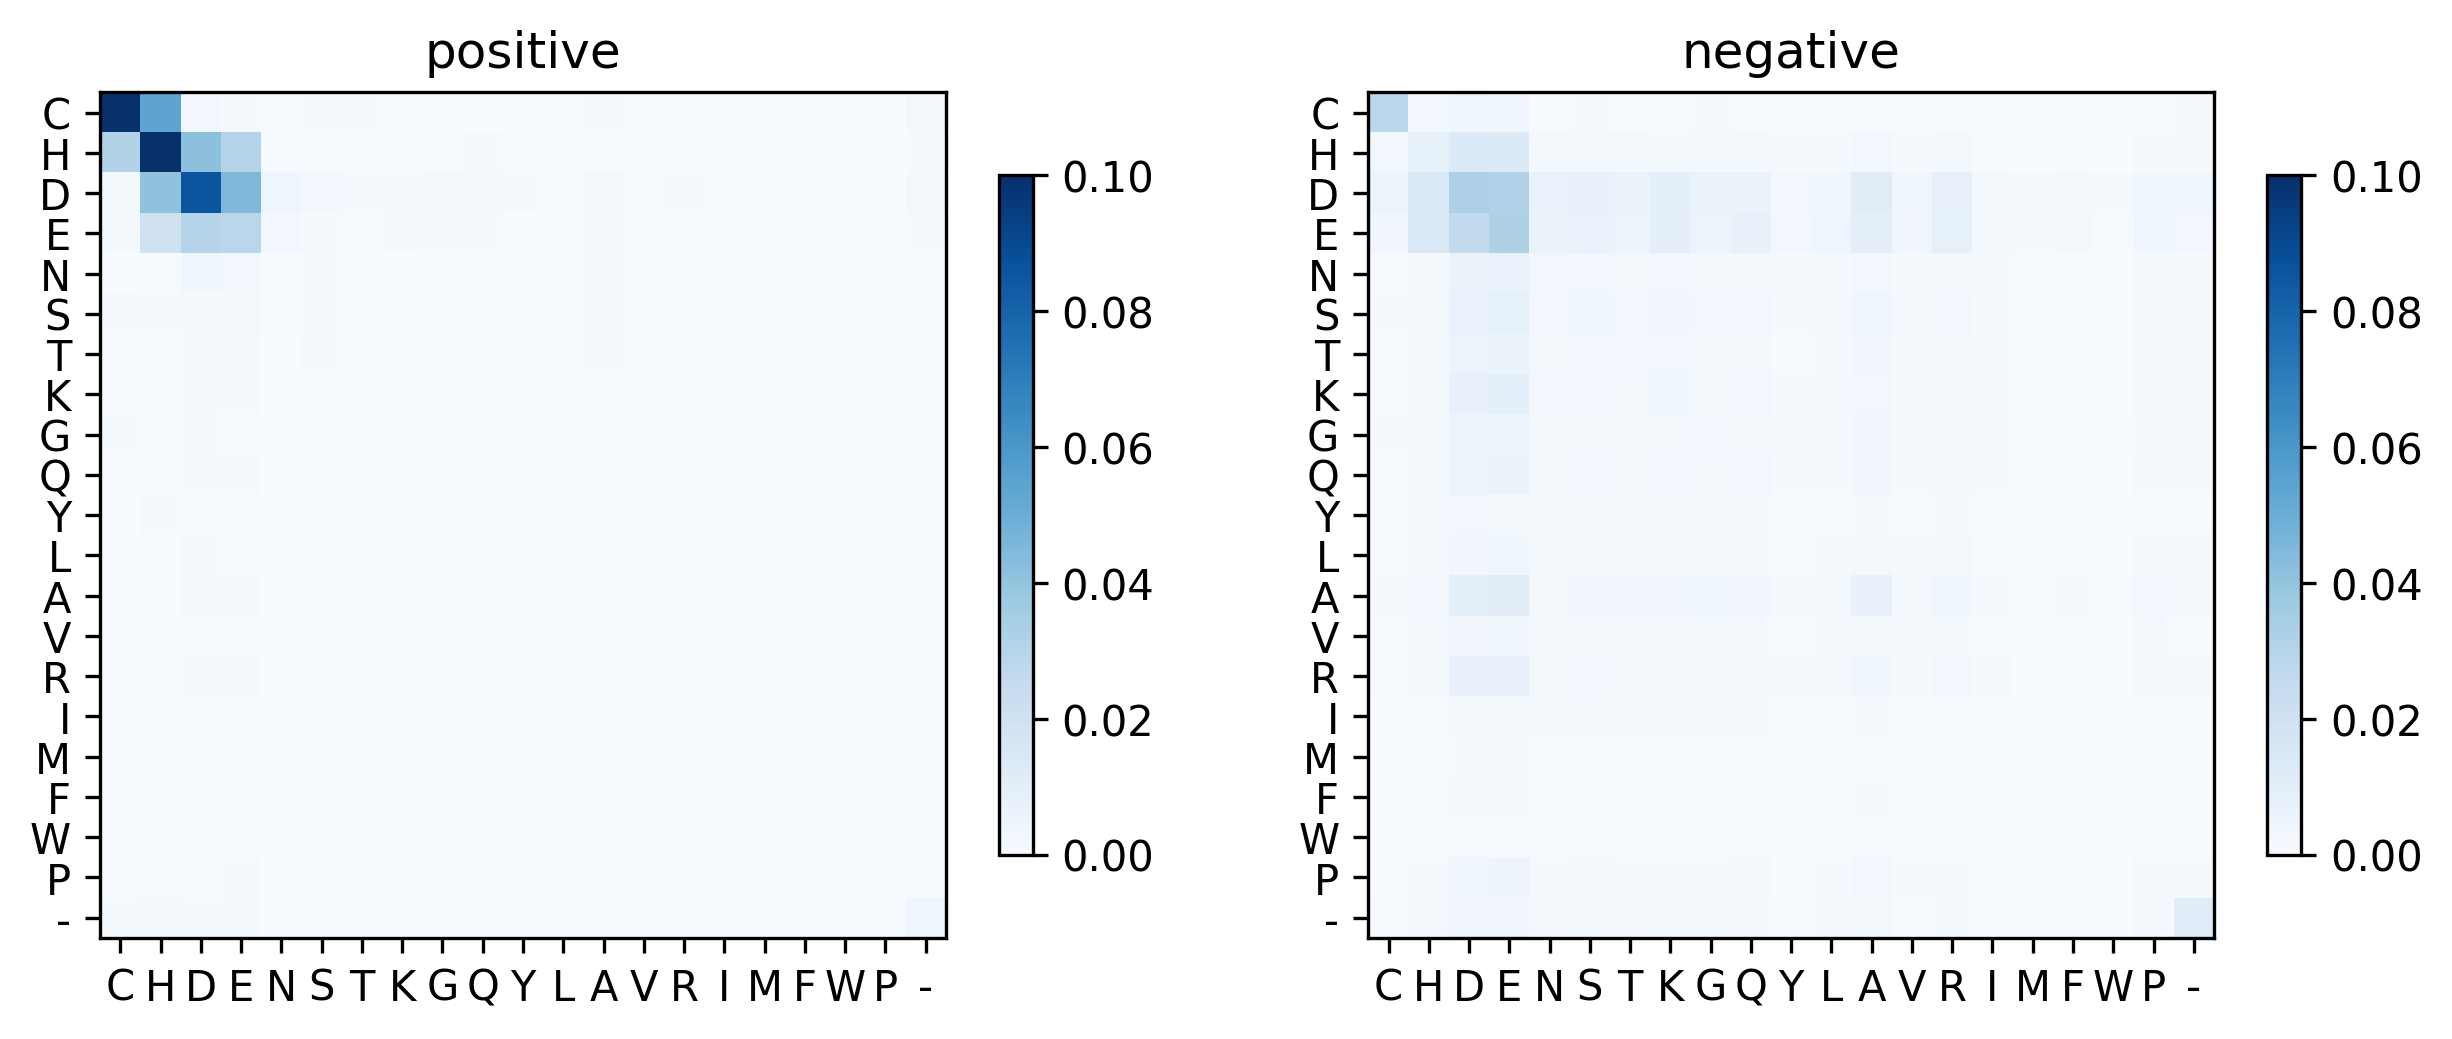

In [58]:
ps_mtx=dataset[np.where(dataset[:,1]==1)][:,0]
print(ps_mtx.shape)
ave_ps=np.sum(ps_mtx)/(np.where(dataset[:,1]==1)[0].shape[0])

ng_mtx=dataset[np.where(dataset[:,1]==0)][:,0]
ave_ng=np.sum(ng_mtx)/(np.where(dataset[:,1]==0)[0].shape[0])
print(ng_mtx.shape)

plt.figure(figsize=(10,6),dpi=300)
ax1=plt.subplot(121)
im1=ax1.imshow(ave_ps,cmap='Blues',vmin=0,vmax=.1)
plt.colorbar(im1,shrink=0.5)
ax1.set_xticks(range(21))
ax1.set_xticklabels(alphabet)
ax1.set_yticks(range(21))
ax1.set_yticklabels(alphabet,rotation=0)
xminorLocator = plt.MultipleLocator(0.5) 
yminorLocator = plt.MultipleLocator(0.5) 
ax1.set_title('positive')

ax2=plt.subplot(122)
im2=ax2.imshow(ave_ng,cmap='Blues',vmin=0,vmax=.1)
plt.colorbar(im2,shrink=0.5)
ax2.set_xticks(range(21))
ax2.set_xticklabels(alphabet)
ax2.set_yticks(range(21))
ax2.set_yticklabels(alphabet,rotation=0)
ax2.set_title('negative')

plt.savefig('frequency matrix_v3.eps',format='eps',dpi=300)
plt.show()

In [ ]:
X=list()
for r in range(dataset.shape[0]):
    X.append(dataset[r][0].flatten())
X=np.array(X)
Y=dataset[:,1]
f=open('all_samples.pkl','wb')
pickle.dump((X,Y),f)
f.close()